In [1]:
import dipy

In [2]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs

In [3]:
from fenics import *
from mshr import *
#from math import pi, sin, cos, sqrt
import math
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import subprocess

In [4]:
fname = 'dMRI_data/ss-ras_data.nii.gz' 
bval_fname = 'dMRI_data/ss-ras.bval' 
bvec_fname = 'dMRI_data/ss-ras.bvec'

data, affine = load_nifti(fname)
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
dims = data.shape
print('data.shape (%d, %d, %d, %d)' % dims)

data_float = data.astype(np.float32)

dataMaxVal = int(max(data.flatten()))
dataMinVal = int(min(data.flatten()))

print('b values: ', bvals)
print('b vectors: ', bvecs)

data.shape (104, 104, 72, 32)
b values:  [  0. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700.   0. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700.]
b vectors:  [[ 0.          0.          0.        ]
 [ 0.22293058 -0.49968055 -0.83703119]
 [-0.17871778 -0.49333411 -0.85128242]
 [-0.37542525 -0.14225766 -0.91587037]
 [ 0.41157657 -0.72193778 -0.556247  ]
 [ 0.19853516 -0.93616748 -0.29012811]
 [ 0.84751403 -0.52907634 -0.04240569]
 [ 0.73912424 -0.51868695 -0.42972025]
 [ 0.43850514 -0.15385152 -0.88546205]
 [ 0.75664991 -0.17243032 -0.63067305]
 [ 0.62896943 -0.74815804  0.21132247]
 [ 0.30347744 -0.94898587  0.0855993 ]
 [ 0.28489485 -0.54959691  0.78535217]
 [ 0.62077832 -0.54730117  0.56133366]
 [ 0.97062433 -0.19699152  0.13814011]
 [ 0.83273727 -0.20222756  0.51541471]
 [-0.03439669 -0.75075191  0.65968806]
 [-0.02572841 -0.94997877  0.31125325]
 [-0.68088585 -0.5256443   0.50999278]
 [-0.36761704 -0.53581387  0.76010603]
 [-

In [5]:
#Input volume number
k = 25

In [6]:
#To select well distruted (farthes pointing vectors in 3D)
def calc_distances(p0, points):
    return np.minimum(((p0 - points)**2).sum(axis=1), ((-p0 - points)**2).sum(axis=1))
    #return ((p0 - points)**2).sum(axis=1)
    
def farthestPts(pts, K):
    farthest_pts = np.zeros((K, 3))
    pts_inds = np.zeros(K)
    #farthest_pts[0] = pts[np.random.randint(len(pts))]
    farthest_pts[0] = pts[1]
    pts_inds[0] = 1
    distances = calc_distances(farthest_pts[0], pts)
    for i in range(1, K):
        farthest_pts[i] = pts[np.argmax(distances)]
        pts_inds[i] = np.argmax(distances)
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
    return farthest_pts, pts_inds
sub_bvecs, sub_indcs = farthestPts(bvecs, k)
print('b sub vectors: ', sub_bvecs)
print('b sub vector indecs ', sub_indcs)

b sub vectors:  [[ 0.22293058 -0.49968055 -0.83703119]
 [ 0.62077832 -0.54730117  0.56133366]
 [-0.66621846 -0.72867197  0.15871401]
 [ 0.          0.          0.        ]
 [-0.70739847 -0.15345097 -0.68995672]
 [-0.15568012  0.20317107 -0.96668768]
 [ 0.19853516 -0.93616748 -0.29012811]
 [ 0.75664991 -0.17243032 -0.63067305]
 [-0.38958105 -0.71641558 -0.57877034]
 [-0.03439669 -0.75075191  0.65968806]
 [-0.98415816 -0.1684573   0.05526903]
 [ 0.84751403 -0.52907634 -0.04240569]
 [-0.36761704 -0.53581387  0.76010603]
 [ 0.43850514 -0.15385152 -0.88546205]
 [ 0.83273727 -0.20222756  0.51541471]
 [-0.71661639 -0.50075305 -0.48549715]
 [ 0.41157657 -0.72193778 -0.556247  ]
 [-0.17871778 -0.49333411 -0.85128242]
 [-0.37542525 -0.14225766 -0.91587037]
 [-0.02572841 -0.94997877  0.31125325]
 [-0.87868327 -0.18046372  0.44198251]
 [-0.24489762 -0.19681381  0.9493627 ]
 [-0.68088585 -0.5256443   0.50999278]
 [-0.33905616 -0.93877596  0.06115915]
 [ 0.73912424 -0.51868695 -0.42972025]]
b sub ve

In [7]:
# Selecting one b0 and six b700 voxels
sub_indcs = sub_indcs.astype(int)
sub_bvals = bvals[sub_indcs]
print(sub_bvals)

sub_data = data_float[:, :, :, sub_indcs]
print(sub_data.shape)

##Save left volumes as Nifti file
#sub_data_int = sub_data.astype(int)
#subVols = nib.Nifti1Image(sub_data_int, affine=np.eye(4))
#nib.nifti1.save(subVols, os.getcwd()+'{}'.format(r'/cosine_weighted_averaging/sub_vols.nii.gz'))

#Removing input data (1+6 volumes)
left_data = np.delete(data_float, sub_indcs, axis=3)
print(left_data.shape)

##Save left volumes as Nifti file
#left_data_int = left_data.astype(int)
#predictedVols = nib.Nifti1Image(left_data_int, affine=np.eye(4))
#nib.nifti1.save(predictedVols, os.getcwd()+'{}'.format(r'/cosine_weighted_averaging/left_vols.nii.gz'))

[700. 700. 700.   0. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.]
(104, 104, 72, 25)
(104, 104, 72, 7)


In [8]:
##Registration
#b0_ind = np.where(sub_bvals==0)[0]
#regis_sub_data = subprocess.run(["eddy_correct", "cosine_weighted_averaging/sub_vols.nii.gz", "cosine_weighted_averaging/registered_data/sub_data_lowb-corrected.nii.gz", str(b0_ind[0])])
#print("The exit code was: %d" % regis_sub_data.returncode)

In [9]:
#Load registrated data
#nameStr = 'LH_all_voxels/registered_data/kFrame_correct15.nii.gz'     
#sub_regis_data, sub_regis_affine = load_nifti(nameStr)
#dims_sub = sub_regis_data.shape
#print('data.shape (%d, %d, %d, %d)' % sub_regis_data.shape)
#print('Type: ', sub_regis_data.dtype)

In [10]:
#Volume Index to predict
nextIter_sub_bvecs, nextIter_sub_indcs = farthestPts(bvecs, k+1)
print('b sub vector indecs ', nextIter_sub_indcs)
nextIter_sub_indcs = nextIter_sub_indcs.astype(int)
inter_sub_indcs = [i for i in nextIter_sub_indcs if i not in sub_indcs]
if len(inter_sub_indcs) != 0: 
    left_indcs = inter_sub_indcs[0]
else:
    left_indcs = np.arange(data.shape[3])
    left_indcs = np.delete(left_indcs, sub_indcs)
    print(left_indcs)
    left_indcs = left_indcs[0]
print("Predicted volume: ", left_indcs)
bvec_volPredict = bvecs[left_indcs]
print("Prediction b vector: ", bvec_volPredict)

b sub vector indecs  [ 1. 13. 23.  0. 27. 20.  5.  9. 26. 16. 31.  6. 19.  8. 15. 28.  4.  2.
  3. 17. 30. 22. 18. 24.  7. 10.]
Predicted volume:  10
Prediction b vector:  [ 0.62896943 -0.74815804  0.21132247]


In [11]:
def project_point_onto_affine_subspace(p, V):
    """Projects a point onto an affine subspace

    p.shape = (N,)   OR (num_pts, N) for vectorization over many points / affine subspaces
    V.shape = (k, N) OR (num_pts, k, N) for vectorization

    N = dimension of ambient space
    k-1 = dimension of affine subspace

    For a single point / affine subspace:
        - p is the point in R^N to be projected onto the affine subspace
        - The affine subspace is the set of all affine combinations
        of rows, V[i,:], of the matrix V

    Vectorization:
    For many points / affine subspaces, each point is
    projected onto its corresponding affine subspace
        p[i,:] is the ith point
        V[i,:,:] is the matrix defining the ith affine subspace

    Example usage:
        import numpy as np
        spatial_dim = 3
        p1 = np.random.randn(spatial_dim)
        V1 = np.array([[2., 0., 0.],
                      [2., 1., 0.],
                      [2., 0., 1.]])
        p2 = np.random.randn(spatial_dim)
        V2 = np.array([[0., 3., 0.],
                       [1., 3., 0.],
                       [0., 3., 1.]])
        p = np.stack([p1, p2])
        V = np.stack([V1, V2])
        projected_p, affine_coordinates = project_point_onto_affine_subspace(p, V)
        projected_p1 = projected_p[0,:]
        projected_p2 = projected_p[1,:]
        print('p1=', p1)
        print('projected_p1=', projected_p1)
        print('p2=', p2)
        print('projected_p2=', projected_p2)
    """
    if len(p.shape) == 1:
        PP = p.reshape((1, p.shape[0]))
        VV = V.reshape((1, V.shape[0], V.shape[1]))
    else:
        PP = p
        VV = V
    num_pts, k, N = VV.shape

    if k == 1:
        affine_coordinates = np.ones((num_pts, 1))
    else:
        VV0 = VV[:, 0, :].reshape((num_pts, 1, N))
        dVV = VV[:, 1: :].reshape((num_pts, k-1, N)) - VV0
        dPP = PP.reshape((num_pts, 1, N)) - VV0

        if k == 2:
            PHI = np.sum(dVV * dVV, axis=-1).reshape((num_pts))
            RHS = np.sum(dVV * dPP, axis=-1).reshape((num_pts))
            cc_rest = (RHS / PHI).reshape((num_pts, 1))
        else:
            PHI = np.einsum('xiz,xjz->xij', dVV, dVV) # shape = (num_pts, k-1, k-1)
            iPHI = np.linalg.inv(PHI) # shape = (num_pts, k-1, k-1)

            RHS = np.sum(dVV * dPP, axis=-1)  # shape = (num_pts, k-1)
            cc_rest = np.einsum('pij,pj->pi', iPHI, RHS)  # shape = (num_pts, k-1)

        cc_first = (1. - np.sum(cc_rest, axis=1)).reshape((num_pts, 1))
        affine_coordinates = np.concatenate([cc_first, cc_rest], axis=1) # shape = (num_pts, k)

    PP_projected = np.einsum('pi,pij->pj', affine_coordinates, VV) # shape = (num_pts, N)

    if len(p.shape) == 1:
        PP_projected = PP_projected.reshape(-1)
        affine_coordinates = affine_coordinates.reshape(-1)
    return PP_projected, affine_coordinates

def powerset(s):
    # NOT MY CODE. FROM USER "hughdbrown" ON STACKOVERFLOW HERE:
    # https://stackoverflow.com/a/1482320/484944
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

def closest_point_on_simplex(p, V):
    """Projects a point onto a simplex (triangle, tetrahedron, etc)

    p.shape = (N,)   OR (num_pts, N) for vectorization over many points/simplices
    V.shape = (k, N) OR (num_pts, k, N) for vectorization

    N = dimension of ambient space
    k-1 = dimension of simplex

    For a single point/simplex:
        - p is the point in R^N to be projected onto the simplex
        - The simplex is the set of all convex combinations
        of rows, V[i,:], of the matrix V

    Vectorization:
    For many points/simplices, each point is
    projected onto its corresponding simplex
        p[i,:] is the ith point
        V[i,:,:] is the matrix defining the ith simplex

    Example usage:
        import numpy as np
        import matplotlib.pyplot as plt
        p1 = np.array([1.1, 0.4])
        V1 = np.array([[0., 0.],
                       [0., 1.],
                       [1., 0.]])
        p2 = np.array([-0.3, 1.1])
        V2 = np.array([[-1.0, 0.],
                       [0.,   0.],
                       [-0.5, 0.5]])
        p = np.stack([p1, p2])
        V = np.stack([V1, V2])
        projected_p = closest_point_on_simplex(p, V)
        projected_p1 = projected_p[0,:]
        projected_p2 = projected_p[1,:]
        plt.figure()
        t1 = plt.Polygon(V1)
        plt.gca().add_patch(t1)
        plt.plot([p1[0], projected_p1[0]],
                 [p1[1], projected_p1[1]], 'r')
        t2 = plt.Polygon(V2)
        plt.gca().add_patch(t2)
        plt.plot([p2[0], projected_p2[0]],
                 [p2[1], projected_p2[1]], 'r')
        plt.gca().set_aspect('equal')
        plt.show()
    """
    if len(p.shape) == 1:
        PP = p.reshape((1, p.shape[0]))
        VV = V.reshape((1, V.shape[0], V.shape[1]))
    else:
        PP = p
        VV = V
    num_pts, k, N = VV.shape

    subsets = list(powerset(list(range(k)))) # e.g., [[], [0], [1], [2], [0,1], [0,2], [1,2], [0,1,2]]
    QQ = list()
    CC = list()
    for s in subsets:
        if s:
            simplicial_facet = VV[:,s,:]
            Q, C = project_point_onto_affine_subspace(PP, simplicial_facet)
            QQ.append(Q)
            CC.append(C)

    distances = np.stack([np.linalg.norm(Q - PP, axis=-1) for Q in QQ]) # shape=(num_facets, num_pts)

    good_inds = np.stack([(np.all(0. <= C, axis=1) & np.all(C <= 1., axis=1)) for C in CC]) # shape=(num_facets, num_pts)
    bad_inds = np.logical_not(good_inds)
    distances[bad_inds] = np.inf
    closest_inds = np.expand_dims(np.argmin(distances[:, :, None], axis=0), axis=0)

    QQ_stack = np.stack(QQ) # shape=(num_facets, num_pts, N)
    PP_projected = np.take_along_axis(QQ_stack, closest_inds, axis=0)[0,:,:]

    if len(p.shape) == 1:
        PP_projected = PP_projected.reshape(-1)
    return PP_projected

def closest_point_in_mesh(p, mesh):
    """Finds the nearest point in a mesh to a given point
    p is the point or points (numpy array)
    mesh is the fenics/dolfin mesh

    p.shape = (N,) OR (num_pts, N) for vectorization over many points
    N = dimension of ambient space

    Example usage:
        import numpy as np
        import dolfin as dl
        import matplotlib.pyplot as plt
        mesh = dl.UnitSquareMesh(13,9)
        num_pts = 20
        p = np.random.randn(num_pts, 2) + np.array([0.5, 0.5])
        closest_p = closest_point_in_mesh(p, mesh)
        plt.figure()
        dl.plot(mesh)
        for ii in range(num_pts):
            plt.plot([p[ii,0], closest_p[ii,0]], [p[ii,1], closest_p[ii,1]], 'b')
            plt.plot(p[ii,0], p[ii,1], '*k')
            plt.plot(closest_p[ii,0], closest_p[ii,1], '.r')
        plt.show()
    """
    if len(p.shape) == 1:
        PP = p[None,:]
    else:
        PP = p
    num_pts, N = PP.shape
    tdim = mesh.topology().dim()
    k = tdim + 1

    VV = np.zeros((num_pts, k, N))
    bbt = mesh.bounding_box_tree()
    for ii in range(num_pts):
        pi = PP[ii,:]
        closest_entity, closest_distance = bbt.compute_closest_entity(Point(pi))
        closest_cell = mesh.cells()[closest_entity]
        vertices_of_closest_cell = mesh.coordinates()[closest_cell, :]
        VV[ii, :, :] = vertices_of_closest_cell

    closest_PP = closest_point_on_simplex(PP, VV)

    if len(p.shape) == 1:
        closest_PP = closest_PP.reshape(-1)
    return closest_PP

In [12]:
#center = Point(0.0, 0.0, 0.0)
#sphere = Sphere(center,1.0)
#mesh = generate_mesh(sphere,5) # 20 specify the resolution of the mesh
#plot(mesh)

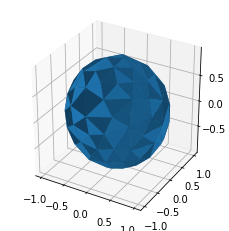

In [13]:
# Mesh and function space
sphere = Sphere(Point(0.0, 0.0, 0.0), 1.0)
vmesh = generate_mesh(sphere, 5)
mesh = BoundaryMesh(vmesh, "exterior")
plot(mesh)

In [14]:
for ind in nextIter_sub_indcs:
    print(ind)

1
13
23
0
27
20
5
9
26
16
31
6
19
8
15
28
4
2
3
17
30
22
18
24
7
10


In [15]:
inpaintedImg_3D = np.zeros((dims[0], dims[1], dims[2]))
bvec_volPredict = bvecs[left_indcs]
for i in range(dims[0]):
    print("IIIIIIIIIIII: ", i)
    for j in range(dims[1]):
        for k in range(dims[2]):
            #V = FunctionSpace(mesh, "CG", 2)
            V = FunctionSpace(mesh, "P", 1)

            # get coordinates of DOFs
            dof_coords = V.tabulate_dof_coordinates()
            
            bcs = []
            #cnt = 0
            for ind in sub_indcs:
                if ind!=0:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 
            
                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(V, Constant(data_float[i,j,k,ind]),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(V, Constant(data_float[i,j,k,ind]),
                                     'near(x[0], {x}) && near(x[1], {y})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                #print(ind, cnt)
                #cnt = cnt+1
            
            u = TrialFunction(V) 
            v = TestFunction(V)
            w = Function(V)      

            x = SpatialCoordinate(mesh)
            # Defining spherical coordinates
            #theta = Expression("atan2(x[1],x[0])", degree=2)
            #phi = Expression("acos(x[2]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))", degree=2)
            phi = Expression("atan2(x[1],x[0])", degree=2)
            theta = Expression("acos(x[2]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))", degree=2)
            
            a2 = u.dx(1)*v.dx(1)
            a3 = (Constant(1.)/sin(theta)**2)*(u.dx(2)*v.dx(2))
            a4 = (cos(theta)/sin(theta))*u.dx(1)*v
            a = (a2+a3-a4)*dx
    
            #a1 = (sin(theta)*sin(theta)*sin(phi)*sin(phi)+cos(theta)*cos(phi)/sin(theta))*(u.dx(0)*v.dx(0))
            #a2 = (cos(theta)*cos(theta)*sin(phi)*sin(phi)+cos(phi)*cos(phi))*(u.dx(1)*v.dx(1))
            #a3 = (sin(phi)**2/sin(theta)**2)*(u.dx(2)*v.dx(2))
            #a4 = (-sin(theta)*sin(phi)*sin(phi)*cos(theta)+cos(theta)*cos(phi)*cos(phi)*sin(theta))*(u.dx(0)*v.dx(1))
            #a5 = (-cos(theta)*cos(phi)*sin(phi))*(u.dx(0)*v.dx(2))
            #a6 = (-cos(theta)*sin(phi)*sin(phi))*(u.dx(1)*v.dx(2))
            #a7 = (cos(theta)*sin(phi))*(u.dx(0)*v)
            #a8 = (-cos(theta)*cos(theta)*sin(phi)/sin(theta))*(u.dx(1)*v)
            #a = (a1+a2+a3+a4+a5+a6+a7+a8)*dx
    
            f = Constant(0.0)

            L = f*v*dx
            solve(a == L, w, bcs)
    
            # Save solution to file in VTK format
            #vtkfile = File('LH_all_voxels/solution_' + str(i) + '_' + str(j) + '_' + str(k) + '.pvd')
            #vtkfile << w
            
            #Volume Prediction
            closest_p = closest_point_in_mesh(bvec_volPredict, mesh)
            #print(bvecs[27])
            #print(closest_p)
            #print(w(closest_p))
            
            inpaintedImg_3D[i,j,k] = w(closest_p)

IIIIIIIIIIII:  0
IIIIIIIIIIII:  1
IIIIIIIIIIII:  2
IIIIIIIIIIII:  3
IIIIIIIIIIII:  4
IIIIIIIIIIII:  5
IIIIIIIIIIII:  6
IIIIIIIIIIII:  7
IIIIIIIIIIII:  8
IIIIIIIIIIII:  9
IIIIIIIIIIII:  10
IIIIIIIIIIII:  11
IIIIIIIIIIII:  12
IIIIIIIIIIII:  13
IIIIIIIIIIII:  14
IIIIIIIIIIII:  15
IIIIIIIIIIII:  16
IIIIIIIIIIII:  17
IIIIIIIIIIII:  18
IIIIIIIIIIII:  19
IIIIIIIIIIII:  20
IIIIIIIIIIII:  21
IIIIIIIIIIII:  22
IIIIIIIIIIII:  23
IIIIIIIIIIII:  24
IIIIIIIIIIII:  25
IIIIIIIIIIII:  26
IIIIIIIIIIII:  27
IIIIIIIIIIII:  28
IIIIIIIIIIII:  29
IIIIIIIIIIII:  30
IIIIIIIIIIII:  31
IIIIIIIIIIII:  32
IIIIIIIIIIII:  33
IIIIIIIIIIII:  34
IIIIIIIIIIII:  35
IIIIIIIIIIII:  36
IIIIIIIIIIII:  37
IIIIIIIIIIII:  38
IIIIIIIIIIII:  39
IIIIIIIIIIII:  40
IIIIIIIIIIII:  41
IIIIIIIIIIII:  42
IIIIIIIIIIII:  43
IIIIIIIIIIII:  44
IIIIIIIIIIII:  45
IIIIIIIIIIII:  46
IIIIIIIIIIII:  47
IIIIIIIIIIII:  48
IIIIIIIIIIII:  49
IIIIIIIIIIII:  50
IIIIIIIIIIII:  51
IIIIIIIIIIII:  52
IIIIIIIIIIII:  53
IIIIIIIIIIII:  54
IIIIIIIIIIII:  55
II

In [16]:
inpaintedImg_3D[70,42,56]

104.86495555454522

In [17]:
inpaintedImg_3D[7,2,6]

0.4667800869043914

In [18]:
inpaintedImg_3D[0,4,5]

0.014657616248863487

In [21]:
ni_img = nib.Nifti1Image(inpaintedImg_3D, affine=affine)
nib.save(ni_img, "qspace_LH_volume_image_on_sphere_10.nii")

In [ ]:
np.array_equal(sub_data[...,4],data_float[...,27])

In [ ]:
array_u = nodal_values_u = w.vector()
vertex_values_u = w.compute_vertex_values()

In [ ]:
print(array_u)

In [ ]:
#for i in range(len(array_u)):
    #print(array_u[i])

In [ ]:
min(array_u)

In [ ]:
len(array_u)

In [ ]:
bvecs[1][0]

In [ ]:
bvecs[1][2]

In [ ]:
data_float[63,54,30,1]

In [ ]:
data_float[63,54,30,14]

In [ ]:
data_float[63,54,30,17]

In [ ]:
data_float[63,54,30,20]

In [ ]:
data_float[63,54,30,22]

In [ ]:
data_float[63,54,30,29]

In [ ]:
#error_L2 = errornorm(u_D, w, 'L2')
#vertex_values_u_D = u_D.compute_vertex_values(mesh)
#vertex_values_u = w.compute_vertex_values(mesh)
#error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
#print(error_max)
#print(error_L2)

In [ ]:
bvecs[27]

In [ ]:
x_point = Point(*[bvecs[27]])
mesh.bounding_box_tree().compute_first_entity_collision(x_point)

In [ ]:
#mesh.bounding_box_tree().compute_closest_point(x_point)

In [ ]:
inpaintedImg_3D.shape

In [ ]:
max(inpaintedImg_3D.flatten())

In [32]:
for ind in sub_indcs:
    if ind!=0:
        # find nearest DOF:
        dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
        print('dof {}, x = {}'.format(dof, dof_coords[dof]))
        dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
        print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

dof 30, x = [ 0.18528377 -0.58967831 -0.78112258]
dof 63, x = [-0.14744196  0.44232587  0.88465174]
dof 25, x = [ 0.5852211  -0.49955398  0.62622554]
dof 69, x = [-0.73130955  0.46356867 -0.48650621]
dof 19, x = [-0.77761702 -0.61396778  0.09714365]
dof 91, x = [ 0.64559635  0.70653482 -0.27007483]
dof 33, x = [-0.6910129  -0.26925118 -0.66214922]
dof 60, x = [ 0.63143078 -0.01233229  0.76840418]
dof 71, x = [-0.14911619  0.20924431 -0.96247672]
dof 39, x = [ 0.06035418 -0.23738741  0.96616436]
dof 2, x = [ 0.13042925 -0.95803459 -0.24825776]
dof 95, x = [-0.34141835  0.87243178  0.33310385]
dof 54, x = [ 0.74704578 -0.08775667 -0.65194771]
dof 65, x = [-0.79945812  0.19199626  0.55818978]
dof 16, x = [-0.21698185 -0.6981626  -0.6711731 ]
dof 78, x = [0.25668977 0.69483186 0.66221711]
dof 11, x = [ 0.15430335 -0.77151675  0.6172134 ]
dof 101, x = [ 0.1136599   0.72138422 -0.67405825]
dof 67, x = [-0.9815828  -0.11045769 -0.143277  ]
dof 56, x = [ 0.96597237  0.24807018 -0.03604765]
dof

In [26]:
sub_indcs

array([ 1, 13, 23,  0, 27, 20,  5,  9, 26, 16, 31,  6, 19,  8, 15, 28,  4,
        2,  3, 17, 30, 22, 18, 24,  7])

In [31]:
dof_coords[dof].dtype

dtype('float64')